##I, Franz Masatoshi Yuri, did this TP with Lorenza, although some answers may diverge.

This second practical work, on motion estimation, deals with parametric motion estimation. You have to reuse some of the functions you implemented during the first practical work.

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [98]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from cv2 import copyMakeBorder,BORDER_REPLICATE

# Parametric estimation
In this second practical work, we will work on parametric estimation, both using direct and indirect methods.
## I- Direct parametric estimation
## I-1 Theoretical questions

**Infinite signal**

Let $a: (n,m)\in \mathbb{Z}^2 \rightarrow \mathbb{R}$ be a bi-dimensional signal and $b(n,m)$ a signal of the same type.

**Recall the expression of the 2D discrete time Fourier transform (DTFT).**

Let us suppose that
$\exists c,d \in \mathbb{Z}^2: \forall n,m \in \mathbb{Z}^2,b(n,m) = a(n+c,m+d)$ (that is, $b$ is a translation of $a$). **Compute the DTFT** of $b$ as a function of the one of $a$ and of the displacement $(c,d)$.

**Show that the ratio between the DTFTs is:**
$$
\frac{\hat{b}(\nu_x,\nu_y)}{\hat{a}(\nu_x,\nu_y)} = \exp(i2\pi (c\nu_x + d \nu_y))
$$

- answer

$$
\frac{\hat{b}(\nu_x,\nu_y)}{\hat{a}(\nu_x,\nu_y)} = \frac{\mathcal{F}(b(n,m))}{\mathcal{F}(a(n,m))}
$$

But
$$\mathcal{F}(f(x - x_0, y - y_0)) = \hat{f}(u,v) e^{-j 2\pi (u x_0 + v y_0)}$$

Therefore:
$$
\frac{\mathcal{F}(b(n,m))}{\mathcal{F}(a(n,m))} =
\frac{\mathcal{F}(a(n,m)) \cdot \exp(i2\pi (c\nu_x + d \nu_y))}{\mathcal{F}(a(n,m))}
$$

$$
\frac{\mathcal{F}(a(n,m)) \cdot \exp(i2\pi (c\nu_x + d \nu_y))}{\mathcal{F}(a(n,m))} = \exp(i2\pi (c\nu_x + d \nu_y))
$$



**Finite signal**

Now, $a: (n,m) \in \{0,1,...,N-1\}^2 \rightarrow \mathbb{R}$ and $b(n,m)$ are both finite signals. In that case, we use the Discrete Fourier Transform (DFT) rather than the DTFT.

**Recall the expression of the DFT.**

**Under which hypotheses is the ratio between $a$'s and $b$'s DFT a linear phase signal?**
$$
\frac{\hat{B}(k_x,k_y)}{\hat{A}(k_x,k_y)} = \exp\left(\frac{2i\pi(ck_x + dk_y)}{N}\right)
$$

The essential assumption about the signal made in the DFT is that it is periodical. Assuming that, as well as that the image is squared with dimentions N, it follows that:




$$
\mathcal{F}(a(n - c, m - d)) = \hat{a}(k,l) e^{-j 2\pi \left( \frac{k c}{N} + \frac{l d}{M} \right)}
$$

Therefore:

$$
\frac{\mathcal{F}(b(n,m))}{\mathcal{F}(a(n,m))} =
\frac{\hat{a}(k,l) e^{-j 2\pi \left( \frac{k c}{N} + \frac{l d}{M} \right)}}{\hat{a}(k,l)}
$$

$$
\frac{\hat{a}(k,l) e^{-j 2\pi \left( \frac{k c}{N} + \frac{l d}{M} \right)}}{\hat{a}(k,l)}
= e^{-j 2\pi \left( \frac{k c}{N} + \frac{l d}{M} \right)}
$$

For $N = M$ we have:


$$
\frac{\mathcal{F}(b(n,m))}{\mathcal{F}(a(n,m))} = \exp\left(\frac{2i\pi(ck_x + dk_y)}{N}\right)
$$

## I-2 Practical part
First, start to work on the 'ball.mat' image. We will apply a translation to this image and try to estimate the parameter of the translation.

Try by either adding or not some noise into the image.

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7d9df146c690>)

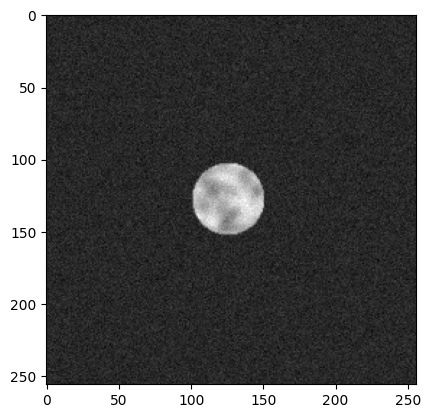

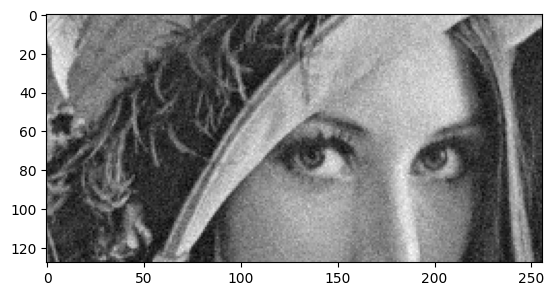

In [130]:
im1_clean = loadmat('ball.mat')['im1']
im1_clean = im1_clean.astype('float')

im_lena_clean = loadmat('lena.mat')['im1']
im_lena_clean = im_lena_clean.astype('float')

N, M = np.shape(im1_clean)
N_lena, M_lena = np.shape(im_lena_clean)
# Potentially add noise to the image
sigma = 10
im1 = im1_clean + np.random.normal(0,sigma,im1_clean.shape)
plt.figure(),plt.imshow(im1,cmap='gray')

im_lena =im_lena_clean + np.random.normal(0,sigma,im_lena_clean.shape)
plt.figure(),plt.imshow(im_lena,cmap='gray')

In the following, we apply a translation to the image. To do that, use the applyAffineMotion function which is already pre-implemented.

In [100]:
def fracMc(ref,mvf,outofbound=20):

    [rows, cols] = np.shape(ref);



    mc_c, mc_r = np.meshgrid(np.arange(cols),np.arange(rows)) # Initial coordinates, used to infer the new coordinates

    mc_r_tmp = mc_r + mvf[:,:,0] # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:,:,1] # Column coordinates, after the movement

    extension = outofbound
    #ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)# Padded image
    ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REFLECT)# Padded image

    mc_r = mc_r_tmp + extension # Row coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_c = mc_c_tmp + extension # Column coordinates, after the movement, in which we want to do the interpolation (in the padded image)

    colMeshGrid, rowMeshGrid = np.meshgrid(np.arange(cols+2*extension),np.arange(rows+2*extension)) # Original coordinates, at which we know the data points


    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1],2))
    points[:,0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:,1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])

    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])


    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols,2))
    points_inter[:,0] = mc_c.reshape(rows*cols)
    points_inter[:,1] = mc_r.reshape(rows*cols)

    motcomp =  griddata(points, values, points_inter,'linear')

    motcomp = motcomp.reshape(rows,cols)

    return motcomp


def applyAffineMotion(x,b,B = np.zeros((2,2)),out = 100):
    N, M = np.shape(x)
    px, py = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1), np.arange(-(N-1)/2,(N-1)/2+1))

    mvfx = b[0] + B[0,0]*px + B[0,1]*py
    mvfy = b[1] + B[1,0]*px + B[1,1]*py

    mvf = np.zeros((np.shape(mvfx)[0],np.shape(mvfx)[1],2))
    mvf[:,:,1] = mvfx
    mvf[:,:,0] = mvfy

    y = fracMc(x,mvf,out)
    return y

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7d9df0347810>)

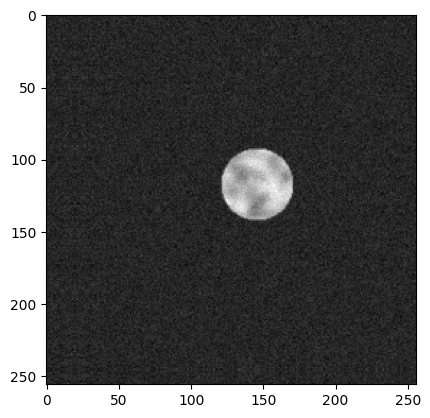

In [131]:
horiz_displacement = -20.
vert_displacement  = 10.
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1,b)
im2_clean = applyAffineMotion(im1_clean,b)

im2_lena_clean = applyAffineMotion(im_lena_clean,b)
im2_lena = applyAffineMotion(im_lena,b)

plt.figure(),plt.imshow(im2,cmap='gray')

Compute the FFT of the two images. Using the indications given in the theroretical part, describe a method with which you can find the parameters of the translation from the two FFTs.

We have that

$$
\frac{\hat{B}(k_x,k_y)}{\hat{A}(k_x,k_y)} = \exp\left(\frac{2i\pi(ck_x + dk_y)}{N}\right).
$$

And we know the functions $\hat{A}$ and $\hat{B}$.

Therefore, to find $c$ and $d$ we can first take a coordinate $(k_x, 0)$ and find the value for $exp\left(\frac{2i\pi ck_x}{N}\right)$, therefore finding c.

Doing the same process we can also find d.

**Answer:**

In [132]:
IM1 = np.fft.fft2(im1)
IM2 = np.fft.fft2(im2)

IM1_clean = np.fft.fft2(im1_clean)
IM2_clean = np.fft.fft2(im2_clean)

IM_lena_clean = np.fft.fft2(im_lena_clean)
IM2_lena_clean = np.fft.fft2(im2_lena_clean)

IM_lena = np.fft.fft2(im_lena)
IM2_lena = np.fft.fft2(im2_lena)

Compute the phase of the Fourier transform.

In [103]:
def angle2D(x):
    a = np.angle(x)

    b1 = np.unwrap(a,axis=0)
    b2 = np.unwrap(b1,axis=1)
    b3 = np.unwrap(a,axis=0)[:,::-1]
    b4 = np.unwrap(b3,axis=1)[:,::-1]

    y = (b2+b4)/2./(-2.*np.pi)
    return y

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7d9df01b1f50>)

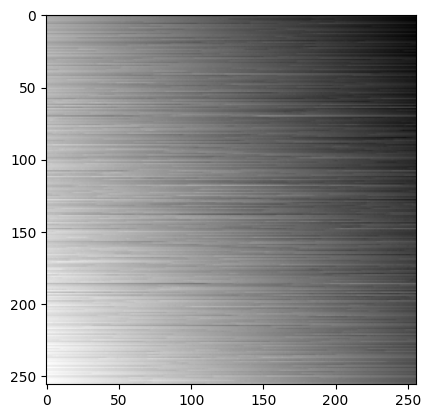

In [133]:
phi = angle2D(IM1/IM2)
plt.figure(),plt.imshow(phi,cmap='gray')

Display phi. Is it a linear plane and why?


The resulting phi is an irregular function added to a inclined plane.

This is expected. Phi is the ratio between $\hat{A}$ and $\hat{B}$, and theoretically we would expect for its phase to be a perfect inclined plane, as it would theoretically be equal to $
\exp\left(\frac{2i\pi(ck_x + dk_y)}{N}\right)
$. However, since we are translating the images without considering them to be cyclical (aperiodical), part of the information is lost in the borders, and therefore the resulting function changes.

Interestingly, the resulting phi is a perfect plane for the moon image without noise. This is because, as the background is completelly black, the translation does not decrease the infromation in the image (it is also interesting to notice this is not the case for the noisy moon image, as now some noise is lost in the translation).


**Answer:**

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7d9df057d850>)

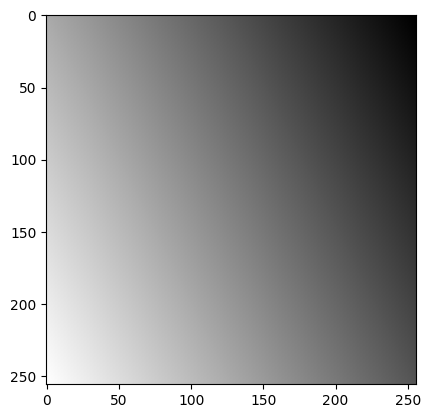

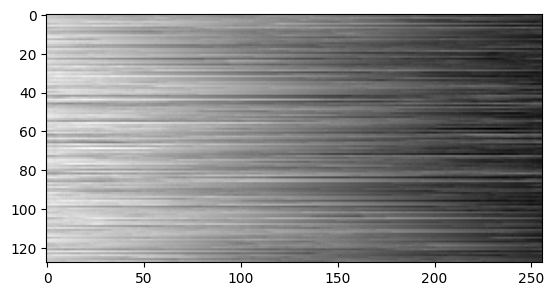

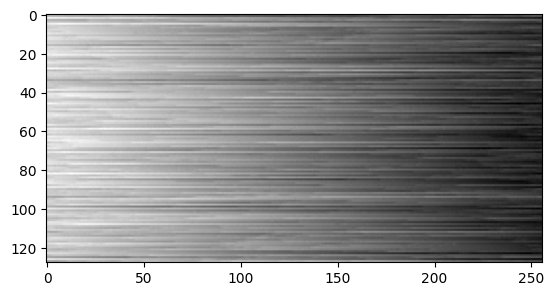

In [105]:
phi_clean = angle2D(IM1_clean/IM2_clean)
plt.figure(),plt.imshow(phi_clean,cmap='gray')

phi_lena_clean = angle2D(IM_lena_clean/IM2_lena_clean)
plt.figure(),plt.imshow(phi_lena_clean,cmap='gray')

phi_lena = angle2D(IM_lena/IM2_lena)
plt.figure(),plt.imshow(phi_lena,cmap='gray')


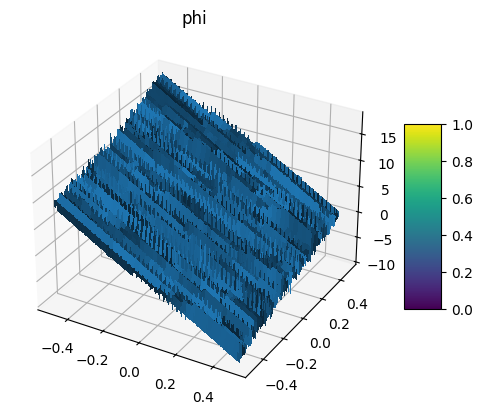

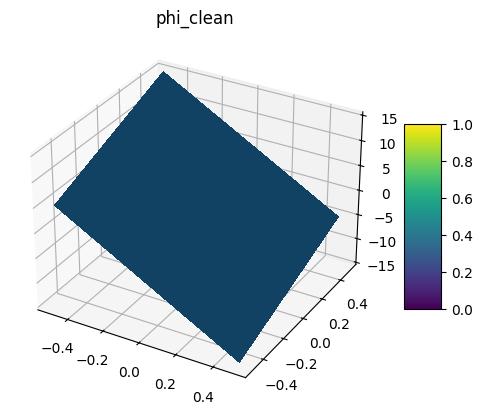

In [134]:
fx, fy = np.meshgrid(np.arange(-(M-1)/2, (M-1)/2 + 1) / M, np.arange(-(N-1)/2, (N-1)/2 + 1) / N)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf1 = ax.plot_surface(fx, fy, phi, linewidth=0, antialiased=False)
ax.set_title('phi')
fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=5)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf2 = ax.plot_surface(fx, fy, phi_clean, linewidth=0, antialiased=False)
ax.set_title('phi_clean')
fig.colorbar(surf2, ax=ax, shrink=0.5, aspect=5)

plt.show()

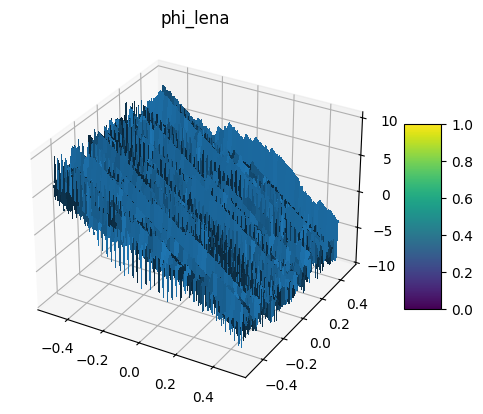

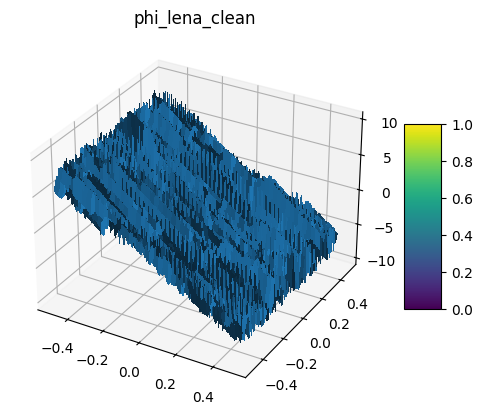

In [122]:

fx, fy = np.meshgrid(np.arange(-(M_lena-1)/2, (M_lena-1)/2 + 1) / M_lena, np.arange(-(N_lena-1)/2, (N_lena-1)/2 + 1) / N_lena)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf1 = ax.plot_surface(fx, fy, phi_lena, linewidth=0, antialiased=False)
ax.set_title('phi_lena')
fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=5)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf2 = ax.plot_surface(fx, fy, phi_lena_clean, linewidth=0, antialiased=False)
ax.set_title('phi_lena_clean')
fig.colorbar(surf2, ax=ax, shrink=0.5, aspect=5)

plt.show()


Translation estimation: to estimate the parameters of the translation, we are now looking for the slope of the plane.

Method 1: estimate it using the median of the gradient. To do that, complete the gradient function.

In [108]:
def gradient(M,stepX=1.,stepY=1.):
# Computes the gradient of an image, over the rows and the column directions. StepY is the assumed gap between the rows and StepX is the assumed gap between the columns
    b_x = np.array([1,0])
    b_y = np.array([0,1])

    gy = (applyAffineMotion(M,b_y) - M) / stepY
    gx = (applyAffineMotion(M,b_x) - M) / stepX


    return gx,gy

In [135]:
gx, gy = gradient(phi,1/M,1/N)
GX = -np.median(gx)
GY = -np.median(gy)

In [136]:
print(GX)
print(GY)

19.050906532266254
-13.266476820167213


Method 2: the code below computes the least Square planar approximation of phi, enabling you how to estimate the parameters of the translation. Explain how it works.

In [111]:
def medianFilter(x,N):
    z = copyMakeBorder(x, N, N, N, N, BORDER_REPLICATE)
    y = np.zeros(np.shape(x))

    for r in range(np.shape(x)[0]):
        for c in range(np.shape(x)[1]):
            tmp = z[r:r+2*N+1,c:c+2*N+1]
            y[r,c] = np.median(tmp)
    return y

In [137]:
phi = phi-phi[int(N/2+2), int(M/2+2)]
t = medianFilter(phi,1)
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = -np.dot(np.linalg.pinv(A),b)

phi_clean = phi_clean-phi_clean[int(N/2+2), int(M/2+2)]
t = medianFilter(phi_clean,1)
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst_clean = -np.dot(np.linalg.pinv(A),b)


In [120]:
print("bEst for the moon image is" + str(bEst))
print("")
print("bEst for the clean moon image is" + str(bEst_clean))


bEst for the moon image is[16.64960172 -9.56518854]

bEst for the clean moon image is[19.99818319 -9.99999288]


In [123]:
phi_lena = phi_lena-phi_lena[int((N_lena-1)/2+2), int((M_lena-1)/2+2)]
t = medianFilter(phi_lena,1)
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst_lena = -np.dot(np.linalg.pinv(A),b)

print("bEst for the lena image is" + str(bEst_lena))
print("")

phi_lena_clean = phi_lena_clean-phi_lena_clean[int(N_lena/2+2), int(M_lena/2+2)]
t = medianFilter(phi_lena_clean,1)
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst_lena_clean = -np.dot(np.linalg.pinv(A),b)

print("bEst for the clean lena image is" + str(bEst_lena_clean))
print("")

bEst for the lena image is[14.25316461  0.42082844]

bEst for the clean lena image is[14.05227389 -0.66186368]



**Relaunch the above code**:
- with and without noise
- with the lena image, instead of the ball image.

Each time, are you able to correctly estimate the translation? Why? Comment your results.

As previously explained, the estimation was precise only for the moon image without noise, as no information was lost in the translation of this image (due to the black background).
For the others, even if some estimations got close (still with an error greater than 10%), they were not precise.

# II-Indirect parametric estimation
In this last part, we will perform indirect parametric estimation. The movement vector field will be estimated by 1) block matching; 2) optic flow. **You have to reuse here the functions that you implemented during the first practical work**. Each time, you will then estimate the translation by taking the median of the estimated vector field.

Perform the experiment without and with noise (you can then take sigma = 2).

Finally, compare all the parametric estimation methods when the translation values are not integer.

##functions from previous TP

In [126]:


def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """


    step = 8
    cont = 4*step

    REF = gaussian_filter(ref,1.)
    CUR = gaussian_filter(cur,1.)

    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf

    pV=np.zeros(2)

    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)

            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC


    return pV

#%%
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block

    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)

    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]

    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]

    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]

        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]

        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)

    pV = pV.ravel()

    return pV


#%%
def me_ssd(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.

    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """

    extension = search

    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE) # To avoid border effect

    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;

    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))

    # Non-regularized search
    if lamb == 0.:
        for r in range(0, cur.shape[0], brow): # for each block in the current image, find the best corresponding block in the reference image
            for c in range(0, cur.shape[1], bcol):
                # current block selection
                B = cur[r:r+brow,c:c+brow] # Block

                # Initialization:

                costMin = np.inf

                Rbest = np.zeros(B.shape)

                # Loop on candidate displacement vectors
                for dcol in range(c-search,c+search): # dcol = candidate displacement vector over the columns
                    for drow in range(r-search,r+search): # rcol = candidate displacement vector over the rows
                        Bref = ref_extended[drow + search:drow + brow + search,dcol + search:dcol + bcol + search]
                        SSD_cost = np.sum((B - Bref)**2)
                        if SSD_cost  < costMin: # Save the results if they are better than the previous ones
                            Rbest = Bref
                            best_drow, best_dcol = drow, dcol
                            costMin = SSD_cost

                mvf[r:r+brow, c:c+bcol, 0] = r - best_drow # Once the loop is over, save the best row displacement field
                mvf[r:r+brow, c:c+bcol, 1] = c - best_dcol # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]= Rbest

    else: # Regularized search
        for r in range(0, cur.shape[0], brow): # for each block in the current image, find the best corresponding block in the reference image
            for c in range(0, cur.shape[1], bcol):
                # current block selection
                B = cur[r:r+brow,c:c+bcol]# Block

                # Initializations
                costMin = np.inf

                Rbest = np.zeros(B.shape)

                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(r,c,brow,bcol,mvf,ref,cur)

                # Loop on candidate vectors
                for dcol in range(c-search,c+search+1): # dcol = candidate displacement vector over the columns
                    for drow in range(r-search, r+search+1): # rcol = candidate displacement vector over the rows
                        Bref = ref_extended[drow + search : drow + brow + search,dcol + search : dcol + bcol + search]
                        cost = (np.linalg.norm(B - Bref) * 2 + lamb * np.linalg.norm(np.array([drow, dcol]) - pV) * 2) # here, encore the REGULARIZED cost function
                        if cost < costMin: # Save the results if they are better than the previous ones
                            costMin = cost
                            Rbest = Bref
                            best_drow = drow
                            best_dcol = dcol


                mvf[r:r+brow,c:c+bcol,0]= r - best_drow # Once the loop is over, save the best row displacement field
                mvf[r:r+brow,c:c+bcol,1]= c - best_dcol # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]=Rbest


    mvf = -mvf # For compatibility with standards

    return mvf, prediction



def displayMVF(I,mvf,subsamp):

    row,col = np.shape(I)

    # Subsample dense MVF
    vectRow = mvf[0:row:subsamp,0:col:subsamp,0]
    vectCol = mvf[0:row:subsamp,0:col:subsamp,1]

    # Determine vector origins
    X,Y = np.meshgrid(np.arange(0,col,subsamp),np.arange(0,row,subsamp))
    X = X + np.floor(subsamp/2.)
    Y = Y + np.floor(subsamp/2.)

    # Show image
    plt.figure()
    plt.imshow(I,cmap='gray')

    plt.quiver(X, Y, vectCol,-vectRow)


    return

##Solution

-20.0
10.0


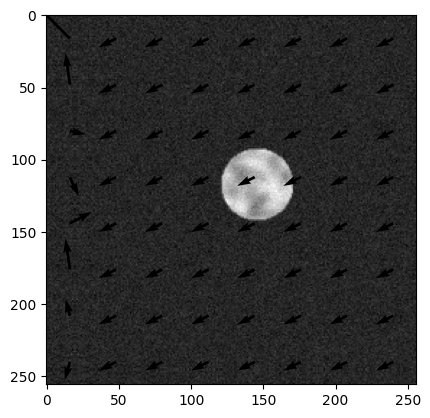

In [152]:
lamb = 0
mvf,prediction = me_ssd(im2,im1,8,8,40,lamb)
displayMVF(im2,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print(bx)
print(by)

-40.0
-40.0


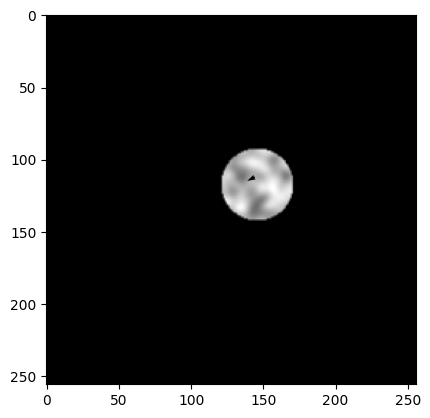

In [163]:
lamb = 0
mvf,prediction = me_ssd(im2_clean,im1_clean,8,8,40,lamb)
displayMVF(im2_clean,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print(bx)
print(by)

-20.0
10.0


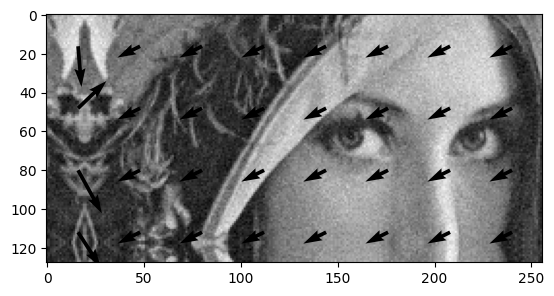

In [159]:
lamb = 0
mvf,prediction = me_ssd(im2_lena,im_lena,8,8,40,lamb)
displayMVF(im2_lena,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print(bx)
print(by)

-20.0
10.0


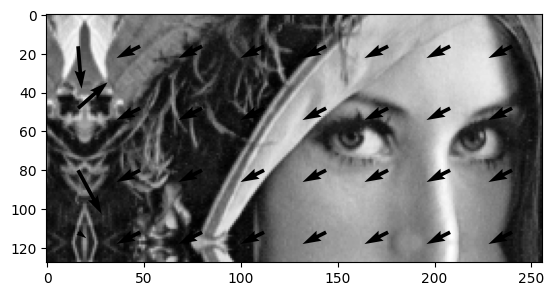

In [161]:
lamb = 0
mvf,prediction = me_ssd(im2_lena_clean,im_lena_clean,8,8,40,lamb)
displayMVF(im2_lena_clean,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print(bx)
print(by)

## conclusion

This method was extremelly efficient for all images, except for the image of the moon without noise. This is probably because the background is absolutelly homogeneous, confusing the algorithm. Interestingly, this is not the case with the noisy image, as the noise is usefull for matching the blocks.

#Estimation with optic flow

##functions from previous TP

In [149]:
def computeDerivatives(im1, im2):
    kernel1D = np.expand_dims((1./12.)*np.array([-1., 8., 0., -8., 1.]),axis=1).T
    fx = convolve2d(im1,kernel1D,'same')
    fy = convolve2d(im1,kernel1D.T,'same')
    ft = convolve2d(im1, 0.25*np.ones((2,2)),'same') + convolve2d(im2, -0.25*np.ones((2,2)),'same');
    fx =-fx;
    fy=-fy;

    return fx, fy, ft


#%%
def HS(im1, im2, uInitial, vInitial, alpha=1, ite=100,blur = 1.):
    """
    Horn-Schunck optical flow method.
    Horn, B.K.P., and Schunck, B.G., Determining Optical Flow, AI(17), No. 1-3, August 1981, pp. 185-203 http://dspace.mit.edu/handle/1721.1/6337

    [u, v] = HS(im1, im2, alpha, ite, uInitial, vInitial, displayFlow)

    Parameters
    ----------
    im1, im2 : np.array
        Two subsequent frames or images.
    uInitial, vInitial: np.array
        Initial values for the (u,v) flow. If well initialized, the flow would converge faster and hence would need less iterations.
    alpha : scalar
        A parameter that reflects the influence of the smoothness term.
    ite : int
        Number of iterations.

    Returns
    -------
    u,v : np.array
        Optical flow.
    """

    im1 = gaussian_filter(im1,blur)
    im2 = gaussian_filter(im2,blur)

    # Set initial value for the flow vectors
    u = uInitial.copy()
    v = vInitial.copy()

    # Estimate spatiotemporal derivatives
    fx, fy, ft = computeDerivatives(im1, im2)

    # Averaging kernel
    kernel_1=np.array([[1./12., 1./6., 1./12.],[1./6., 0., 1./6.],[1./12., 1./6., 1./12.]])

    for i in range(ite):
        # Compute local averages of the flow vectors using kernel_1
        uAvg= convolve2d(u, kernel_1)[1:-1, 1:-1]
        vAvg= convolve2d(v, kernel_1)[1:-1, 1:-1]

        # Compute flow vectors constrained by its local average and the optical flow constraints
        u = uAvg - fx * (uAvg * fx + vAvg * fy + ft) / (alpha**2 + np.linalg.norm(fx + fy + ft) ** 2)
        v = vAvg - fx * (uAvg * fx + vAvg * fy + ft) / (alpha**2 + np.linalg.norm(fx + fy + ft) ** 2)

    u[np.isnan(u)]= 0
    v[np.isnan(v)]= 0
    return u, v

##Solution

-19.997441225981312
9.999350893705461


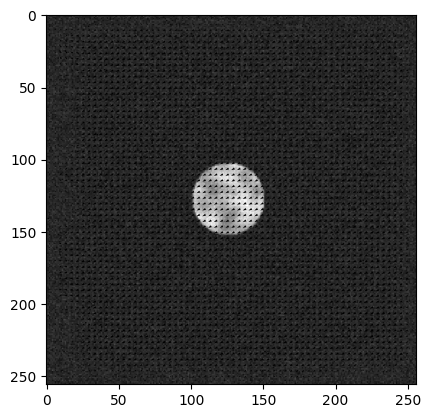

In [153]:
alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im2, im1, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(bx)
print(by)

-39.9635160686429
-39.77134362754984


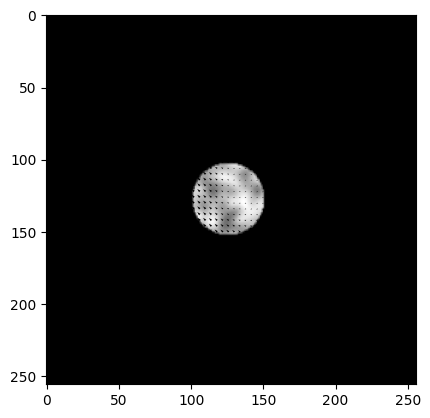

In [164]:
alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im2_clean, im1_clean, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1_clean,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(bx)
print(by)

-19.82316247612335
9.965254016133125


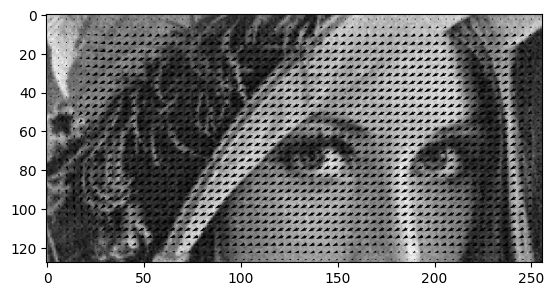

In [160]:
alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im2_lena, im_lena, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im_lena,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(bx)
print(by)

-19.860534518077273
9.934268110098081


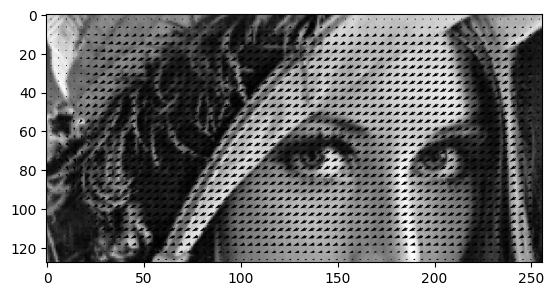

In [162]:
alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im2_lena_clean, im_lena_clean, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im_lena_clean,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(bx)
print(by)

## conclusion

This method was again efficient for all images, except for the image of the moon without noise. This is probably due to the same reason as stated in the estimation with Optical Flow. However, it was less precise for a translation of an integral value than the previous one.

# non-integer translation

##indirect parametric estimation

In [166]:
horiz_displacement = -2.5
vert_displacement  = 0.7
b = np.array([ horiz_displacement, vert_displacement])


im2_lena_clean_float = applyAffineMotion(im_lena_clean,b)
im2_lena_float = applyAffineMotion(im_lena,b)

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7d9def4dfc10>)

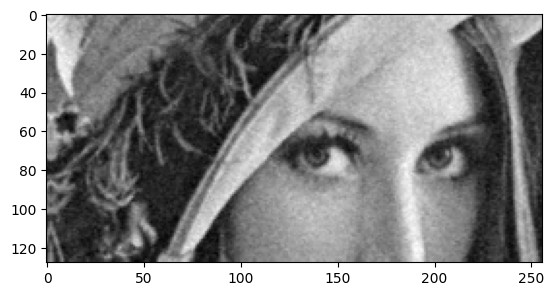

In [168]:
plt.figure(),plt.imshow(im2_lena_float,cmap='gray')

-3.0
1.0


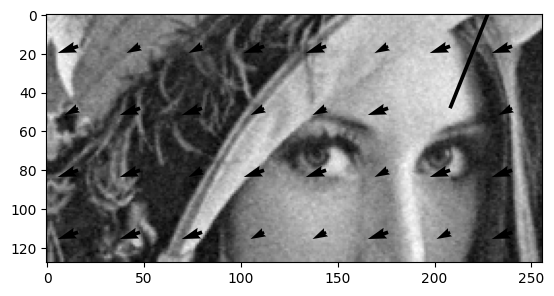

In [169]:
lamb = 0
mvf,prediction = me_ssd(im2_lena_float,im_lena,8,8,40,lamb)
displayMVF(im2_lena_float,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print(bx)
print(by)

-2.0709693338819077
0.8314041769375692


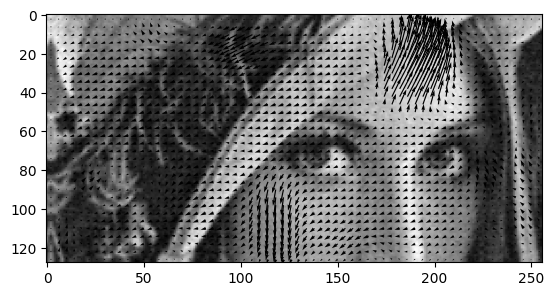

In [173]:
alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im2_lena_float, im_lena, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im2_lena_float,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(bx)
print(by)

##direct parametric estimation

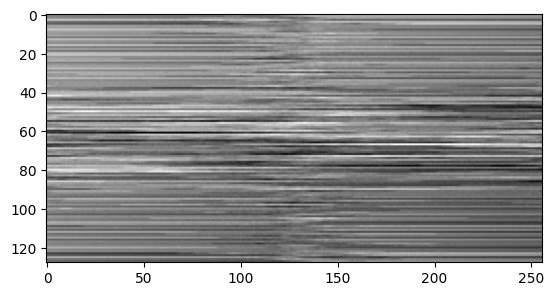

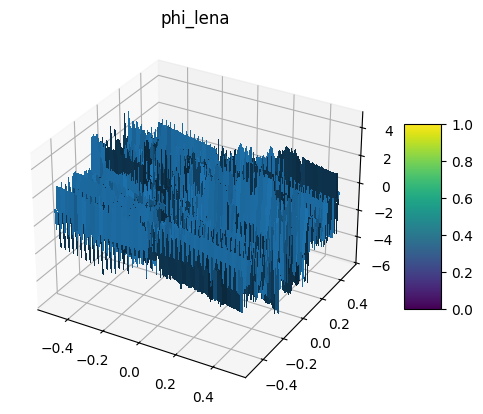

In [174]:

IM_lena_float = np.fft.fft2(im_lena)
IM2_lena_float = np.fft.fft2(im2_lena_float)

phi_lena_float = angle2D(IM_lena_float/IM2_lena_float)
plt.figure(),plt.imshow(phi_lena_float,cmap='gray')



fx, fy = np.meshgrid(np.arange(-(M_lena-1)/2, (M_lena-1)/2 + 1) / M_lena, np.arange(-(N_lena-1)/2, (N_lena-1)/2 + 1) / N_lena)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf1 = ax.plot_surface(fx, fy, phi_lena_float, linewidth=0, antialiased=False)
ax.set_title('phi_lena')
fig.colorbar(surf1, ax=ax, shrink=0.5, aspect=5)

plt.show()


In [177]:
gx, gy = gradient(phi_lena_float,1/M_lena,1/N_lena)
GX = -np.median(gx)
GY = -np.median(gy)

print(GX)
print(GY)

1.685157724081236
9.709119310020542


In [178]:
phi_lena_float = phi_lena_float-phi_lena_float[int((N_lena-1)/2+2), int((M_lena-1)/2+2)]
t = medianFilter(phi_lena_float,1)
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst_lena = -np.dot(np.linalg.pinv(A),b)

print("bEst for the lena image is" + str(bEst_lena))
print("")

bEst for the lena image is[1.41261721 1.60563627]



##conclusion
As expected, the direct parametric methods is not adequate, since the calculation of the DFTS does not work propperly for translations of non integral values.

On the other hand, for the lena images both indirect parametric methods worked better, even though the optical flow yielded better results. For the clean moon image the same issue as before applies.